In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [25]:
#General packages
import pandas as pd
import numpy as np
import pickle
import scipy.stats
from scipy.stats import norm
import scipy as sp

#Visualization packages
import seaborn as sns
import matplotlib.pyplot as plt
# Build figures inline
%matplotlib inline

#NLP packages
import re
import nltk
from wordcloud import WordCloud

#Text preprocessing packages
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Import scikit-learn tools, vectorizers, transformer, and classifiers
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score

# import CountVectorizer and TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

#Classification Models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

#Cross validation packages for hyperparameter tuning
from sklearn.model_selection import GridSearchCV

In [26]:
#load pickled files to DataFrame
cell_phones = pd.read_pickle('../input/amazon-dataset-food/cell_phones_stats.pkl')
cell_phones.head(2)

,reviewText,rating,review_summary
0,They look good and stick good! I just don't li...,4,Looks Good
1,These stickers work like the review says they ...,5,Really great product.


In [27]:
# Labeling the dataset
# label: 1 = high rating (rating = 5), label: 0 = low rating (not5)

def label_func(rating):
    if rating == 5:
        return 1
    else:
        return 0

cell_phones['label_phone'] = cell_phones['rating'].apply(label_func)    # labeling cell_phones dataset
cell_phones.head(2)

,reviewText,rating,review_summary,label_phone
0,They look good and stick good! I just don't li...,4,Looks Good,0
1,These stickers work like the review says they ...,5,Really great product.,1


### Text Pre-Processing to reduce document dimension

- Remove URL.
- Remove numbers and Punctuation
- Convert all characters into lowercase
- Tokenization
- Remove Stopwords
- Lemmatization
- convert list of tokens back into the string

In [28]:
# Remove non-English using NLTK

words = set(nltk.corpus.words.words())

def remove_non_en(text):
    text = " ".join(w.lower() for w in nltk.wordpunct_tokenize(text) if w.lower() in words or not w.isalpha())
    return text

cell_phones['clean_review_phone'] = cell_phones['reviewText'].apply(lambda x: remove_non_en(x)) # cell_phones dataset

cell_phones.head(2)

,reviewText,rating,review_summary,label_phone,clean_review_phone
0,They look good and stick good! I just don't li...,4,Looks Good,0,they look good and stick good ! i just don ' t...
1,These stickers work like the review says they ...,5,Really great product.,1,these stickers work like the review they do . ...


In [29]:
# Preprocessing
stop_words = set(stopwords.words('english'))
lemma = WordNetLemmatizer()

def text_preprocessing(review):
    review = re.sub(r'http\S+', '', review)   # removing URL
    review = re.sub('[^a-zA-Z]', ' ', review) # keep only alpha (removing numbers and punctions)
    review = str(review).lower()              # Lowercase all text
    review = word_tokenize(review)            # Tokenization
    review = [w for w in review if w not in stop_words] # Removing Stopwords
    review = [lemma.lemmatize(word=w, pos='v') for w in review] # Lemmatization
    review = ' '.join(review)
    return review

cell_phones['clean_review_phone'] = cell_phones['clean_review_phone'].apply(text_preprocessing) # cell_phones preprocessing
cell_phones.head(2)

,reviewText,rating,review_summary,label_phone,clean_review_phone
0,They look good and stick good! I just don't li...,4,Looks Good,0,look good stick good like round shape always b...
1,These stickers work like the review says they ...,5,Really great product.,1,stickers work like review stick great stay pho...


## Machine Learning on Cell_phones Dataset

### Create X and y, split train and test data sets

In [32]:
# store the feature matrix (X) and response vector (y) of dataset
# uppercase X because it's an m x n matrix
# lowercase y because it's a m x 1 vector

X_phone = cell_phones.clean_review_phone
y_phone = cell_phones.label_phone

print(X_phone.shape)
print(y_phone.shape)

(193876,)
(193876,)


In [33]:
# split the data into training and test sets
X_train_phone, X_test_phone, y_train_phone, y_test_phone = train_test_split(X_phone, y_phone, random_state=42, test_size=0.3)

# Show the results of the split
print("X Training set sample size:", (X_train_phone.shape[0]))
print("X Testing set sample size:", (X_test_phone.shape[0]))
print("y Training set sample size:", (y_train_phone.shape[0]))
print("y Testing set sample size:", (y_test_phone.shape[0]))

X Training set sample size: 135713
X Testing set sample size: 58163
y Training set sample size: 135713
y Testing set sample size: 58163


### Vectorize, fit, create document-term matrix with two vectorizers

In [34]:
# Instantiate CountVectorizer and TfidfVectorizer
vect = CountVectorizer(min_df=1, ngram_range=(1, 2)) 
tfidf = TfidfVectorizer(min_df=1, ngram_range=(1, 2))

In [35]:
# Apply CountVectorizer to learn training data vocabulary, then use it to create a document-term matrix
X_train_dtm = vect.fit_transform(X_train_phone)

# examine the document-term matrix
X_train_dtm

<135713x1120531 sparse matrix of type '<class 'numpy.int64'>'
	with 8518350 stored elements in Compressed Sparse Row format>

In [36]:
# transform testing data (using fitted vocabulary) into a document-term matrix
X_test_dtm = vect.transform(X_test_phone)
X_test_dtm

<58163x1120531 sparse matrix of type '<class 'numpy.int64'>'
	with 3367346 stored elements in Compressed Sparse Row format>

In [37]:
# Apply TfidfVectorizer to learn training data vocabulary,then use it to create a document-term matrix
X_train_tfidf_phone = tfidf.fit_transform(X_train_phone)

# transform testing data with tfidif vectorizer into document-term matrix
X_test_tfidf_phone = tfidf.transform(X_test_phone)
X_test_tfidf_phone

<58163x1120531 sparse matrix of type '<class 'numpy.float64'>'
	with 3367346 stored elements in Compressed Sparse Row format>

### Build baseline model with Naive Bayes and compare vectorizers

In [38]:
# Instantiate MultinomialNB() classifier for CountVectorizer
nb = MultinomialNB(alpha=1, fit_prior=True)

# Train model
nb.fit(X_train_dtm, y_train_phone)

# Make class predictions for X_test_dtm
y_pred_class = nb.predict(X_test_dtm)

# Calculate F1 Score
f1 = metrics.f1_score(y_test_phone, y_pred_class)

# Confusion matrix
cm = metrics.confusion_matrix(y_test_phone, y_pred_class)

# Calculate predicted probabilities for X_test_dtm
y_pred_prob = nb.predict_proba(X_test_dtm)[:,1]

# Calculate AUC for Naive Bayes model with CountVec
auc = metrics.roc_auc_score(y_test_phone, y_pred_class)

print(vect)
print('\nF1 Score: ', f1)
print('\nConfusion Matrix:\n', cm)
print('\nAUC: ', auc)

CountVectorizer(ngram_range=(1, 2))

F1 Score:  0.794228576440663

Confusion Matrix:
 [[16922  8618]
 [ 5458 27165]]

AUC:  0.7476316222747469


From the confusion matrix we can see, using CountVectorizer, at baseline the Naive Bayes model 27165 reviews were correctly predicted as 'five' (positive) rated (TP) and 16922 were correctly predicted as 'not5' (negative) rated (TN).
However, 8618 reviews were incorrectly predicted to be 'five' (positive) ratings (FP:Type I error) and 5458 reviews were incorrectly predicted to be 'not5' (negative) ratings (FN: Type II error). 

Let's compare it with the TfidfVectorizer.

In [39]:
# COMPARE TFIDF VECTORIZER

# instantiate MultinomialNB() classifier to use on tfidf vectors
nb_tfidf = MultinomialNB(alpha=1, fit_prior=True)

# train the model 
nb_tfidf.fit(X_train_tfidf_phone, y_train_phone)

# Make class predictions for X_test_tidf_baby
y_pred_tfidf = nb_tfidf.predict(X_test_tfidf_phone)

# Calculate F1 Score
f1 = metrics.f1_score(y_test_phone, y_pred_tfidf)

# Confusion matrix
cm = metrics.confusion_matrix(y_test_phone, y_pred_tfidf)

# Calculate predicted probabilities for Xtest1
y_prob_tfidf = nb_tfidf.predict_proba(X_test_tfidf_phone)[:,1]

# Calculate AUC for Naive Bayes model with Tfidf
auc = metrics.roc_auc_score(y_test_phone, y_prob_tfidf)

print(tfidf)
print('\nF1 Score: ', f1)
print('\nConfusion Matrix:\n', cm)
print('\nAUC: ', auc)

TfidfVectorizer(ngram_range=(1, 2))

F1 Score:  0.7931214705469936

Confusion Matrix:
 [[10825 14715]
 [ 1514 31109]]

AUC:  0.8333676713809655


From the confusion matrix we can see, using TFIDF Vectorizer, at baseline the Naive Bayes model 31109 reviews were correctly predicted as 'five' (positive) ratings (TP) and 10825 were correctly predicted as 'not5' (negative) ratings (TN). However, 14715 reviews were incorrectly predicted to be 'five' (positive) ratings (FP) and 1514 reviews were incorrectly predicted to be 'not5' (negative) ratings but they are 'five'(FN).

The TfidfVectorizer with default settings did better in predicting high ratings ('five') but did poorly for low ones ('not5'). Parameters definitely need to be tuned.

### Picking Hyperparameters

I want to look at the __alpha__ and __min_df__ to see if I can make the model better.

#### min_df:

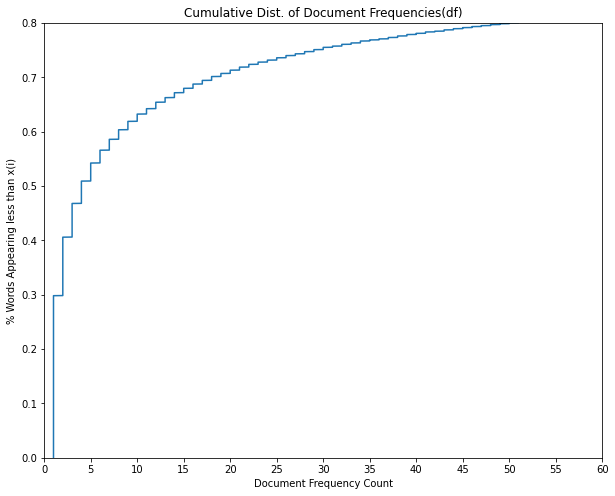

In [40]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(X_train_phone) 
X = X.tocsc() 


#  to get a count of documents in which a word has appeared, sum it across rows
df = np.sum(X>0,axis=0).tolist()[0]

x_df = np.sort(df)
y_df = np.arange(1, len(df) + 1)/len(df)

fig, ax = plt.subplots(figsize=(10,8))
_ = plt.plot(x_df, y_df)
_ = plt.xlim([0,30])
_ = plt.ylim([0, .8])
_ = plt.xticks([x for x in range(0,62,5)])
_ = plt.title('Cumulative Dist. of Document Frequencies(df)')
_ = plt.xlabel('Document Frequency Count')
_ = plt.ylabel('% Words Appearing less than x(i)')

plt.show()

In [41]:
# best min_df for CountVectorizer

values_dict = {}
pos_df = [.1, 1, 2, 3, 4, 5]

for min_df in pos_df:
    vect = CountVectorizer(min_df=min_df, ngram_range=(1, 2)) 
    X_train_dtm = vect.fit_transform(X_train_phone)
    X_test_dtm = vect.transform(X_test_phone)
    nb = MultinomialNB(alpha=1, fit_prior=True)
    nb.fit(X_train_dtm, y_train_phone)
    y_pred_class = nb.predict(X_test_dtm)
    f1 = metrics.f1_score(y_test_phone, y_pred_class)
    y_pred_prob = nb.predict_proba(X_test_dtm)[:,1]
    auc = metrics.roc_auc_score(y_test_phone, y_pred_class)
    values_dict[auc] = [f1, min_df]
    print("AUC: {}, Min_df: {}, F1: {:4f}".format(auc, min_df, f1))
    
best_auc = max(values_dict.keys())
best_f1 = values_dict[max(values_dict.keys())][0]
best_min_df = values_dict[max(values_dict.keys())][1]
print('\n Best Values: \n Min_df: {}, AUC: {}, F1: {:4f}'.format(best_min_df, best_auc, best_f1))

AUC: 0.609668308874328, Min_df: 0.1, F1: 0.686109
AUC: 0.7476316222747469, Min_df: 1, F1: 0.794229
AUC: 0.7488843590108022, Min_df: 2, F1: 0.787748
AUC: 0.7495905982805248, Min_df: 3, F1: 0.786357
AUC: 0.7501324611576053, Min_df: 4, F1: 0.786117
AUC: 0.7496358363843929, Min_df: 5, F1: 0.785165

 Best Values: 
 Min_df: 4, AUC: 0.7501324611576053, F1: 0.786117


In [42]:
# best min_df for TfidfVectorizer
values_dict = {}
pos_df = [.1, 1, 2, 3, 4, 5]

for min_df in pos_df:
    tfidf = TfidfVectorizer(min_df=min_df, ngram_range=(1, 2)) 
    X_train_tfidf_phone = tfidf.fit_transform(X_train_phone)
    X_test_tfidf_phone = tfidf.transform(X_test_phone)
    nb_tfidf = MultinomialNB(alpha=1, fit_prior=True)
    nb_tfidf.fit(X_train_tfidf_phone, y_train_phone)
    y_pred_tfidf = nb_tfidf.predict(X_test_tfidf_phone)
    f1 = metrics.f1_score(y_test_phone, y_pred_tfidf)
    y_prob_tfidf = nb_tfidf.predict_proba(X_test_tfidf_phone)[:,1]
    auc = metrics.roc_auc_score(y_test_phone, y_prob_tfidf)
    values_dict[auc] = [f1, min_df]
    print("AUC: {}, Min_df: {}, F1: {:4f}".format(auc, min_df, f1))

best_auc = max(values_dict.keys())
best_f1 = values_dict[max(values_dict.keys())][0]
best_min_df = values_dict[max(values_dict.keys())][1]
print('\n Best Values: \n Min_df: {}, AUC: {}, F1: {:4f}'.format(best_min_df, best_auc, best_f1))

AUC: 0.673551596942753, Min_df: 0.1, F1: 0.717621
AUC: 0.8333676713809655, Min_df: 1, F1: 0.793121
AUC: 0.8344130878112019, Min_df: 2, F1: 0.802034
AUC: 0.8338085628630214, Min_df: 3, F1: 0.802596
AUC: 0.832852292814057, Min_df: 4, F1: 0.802350
AUC: 0.8323811081731974, Min_df: 5, F1: 0.800929

 Best Values: 
 Min_df: 2, AUC: 0.8344130878112019, F1: 0.802034


Best min_df for CountVectorizer is 4 and for TfidfVectorizer is 2.


__Because of the computing limitation of my PC I will increase the min_df to 50 for both Vectorizers.__

### GridSearchCV

__Run GridSearchCV on best parameters for CountVectorizer__

In [43]:
# run this to get a list of the all available pipe-items unique keys for the grid parameters
sorted(nb.get_params().keys())

['alpha', 'class_prior', 'fit_prior']

In [44]:
# Create a list of parameters for tuning
parameters = {'alpha': (0.001, 0.01, 0.1, 1, 5, 10)}

In [45]:
# Instantiate Vectorizer with new min_df instead of 4 I am using 50 because of computing limitation of my pc
vect = CountVectorizer(min_df=50, ngram_range=(1, 2)) 

# Apply CountVectorizer to learn training data vocabulary, then use it to create a document-term matrix
X_train_dtm = vect.fit_transform(X_train_phone)

# transform testing data (using fitted vocabulary) into a document-term matrix
X_test_dtm = vect.transform(X_test_phone)

# Perform GridSearch on Naive Bayes using the given parameters and CountVectorizer
gs_count = GridSearchCV(MultinomialNB(), parameters, scoring='roc_auc', cv=5)
gs_count.fit(X_train_dtm, y_train_phone)

# View the best score (set to roc_auc) for MultinomialNB with CountVect
print(gs_count)
print('\nBest Score: ', gs_count.best_score_)

# Get best parameters for MultinomialNB with CountVect
print('Best parameters:', gs_count.best_params_)
# Alpha = 1 is the default and picked as best alpha


GridSearchCV(cv=5, estimator=MultinomialNB(),
             param_grid={'alpha': (0.001, 0.01, 0.1, 1, 5, 10)},
             scoring='roc_auc')

Best Score:  0.8016736385988887
Best parameters: {'alpha': 0.001}


__Run GridSearchCV on best parameters for TfidfVectorizer__

In [46]:
# Instantiate Vectorizer with new min_df instead of 2 I am using 50 because of computing limitation of my pc
tfidf = TfidfVectorizer(min_df=50, ngram_range=(1, 2))

# Apply TfidfVectorizer to learn training data vocabulary,then use it to create a document-term matrix
X_train_tfidf_phone = tfidf.fit_transform(X_train_phone)

# transform testing data with tfidif vectorizer into document-term matrix
X_test_tfidf_phone = tfidf.transform(X_test_phone)


# Perform GridSearch on Naive Bayes using the given parameters and CountVectorizer
gs_tfidf = GridSearchCV(MultinomialNB(), parameters, scoring='roc_auc', cv=5)
gs_tfidf.fit(X_train_tfidf_phone, y_train_phone)

# View the best score (set to roc_auc) for MultinomialNB with TfidfVect
print(gs_tfidf)
print('\nBest Score: ', gs_tfidf.best_score_)

# Get best parameters for MultinomialNB with TfidfVect
print('Best parameters:', gs_tfidf.best_params_)

GridSearchCV(cv=5, estimator=MultinomialNB(),
             param_grid={'alpha': (0.001, 0.01, 0.1, 1, 5, 10)},
             scoring='roc_auc')

Best Score:  0.824296914915687
Best parameters: {'alpha': 10}


__Interpretation:__

The Naive Bayes model using a minimum document frequency of 50 for CountVectorizer and TfidfVectorizer performs well. GridSearchCV indicated that the best alpha for TfidfVectorizer were 10 but for CountVectorizer it was 0.001. For the rest of the algorithms I will use the document terms matrix from the TfidfVectorizer because it has better score.

Next I will look further into the text to further improve the model amongst other algorithms and classifiers. 

In [47]:
# Calculate predicted probabilities for X_test_tfidf_phone
y_prob_nb = gs_tfidf.predict_proba(X_test_tfidf_phone)[:,1]

# Calculate AUC for Naive Bayes model with TfidfVectorizer
auc = metrics.roc_auc_score(y_test_phone, y_prob_nb)

print('AUC: ', auc)

AUC:  0.824193697889976


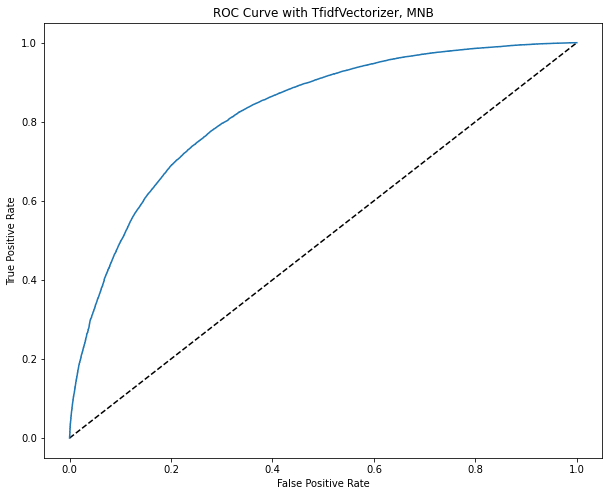

In [48]:
# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test_phone, y_prob_nb)

# Plot ROC curve
plt.figure(figsize=(10,8))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with TfidfVectorizer, MNB')
plt.show()

### Most Predictive Features

In [49]:
words = np.array(tfidf.get_feature_names())

# Create an identity matrix the length of the vocabulary
x = np.eye(X_test_tfidf_phone.shape[1]) 

In [50]:
# Use the model to predict on the identity matrix, and get a list of probabilities for each word
probs = gs_tfidf.predict_log_proba(x)[:,0] 



In [51]:
# Sort for most/least probable words for any give class
ind = np.argsort(probs)

good_words = words[ind[:10]]
bad_words = words[ind[-10:]]

good_prob = probs[ind[:10]]
bad_prob = probs[ind[-10:]]

print("Positive words\t     P(five (positive) | word)")
for w, p in zip(good_words, good_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))
    
print("Negative words\t     P(five (positive) | word)")
for w, p in zip(bad_words, bad_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))

Positive words	     P(five (positive) | word)
    highly recommend 0.89
           love love 0.88
              highly 0.87
     absolutely love 0.85
          thank much 0.84
           love much 0.84
  recommend everyone 0.83
        would highly 0.83
                love 0.82
           love case 0.82
Negative words	     P(five (positive) | word)
           guess get 0.21
             useless 0.20
               trash 0.20
           send back 0.20
               waste 0.19
             get pay 0.18
            one star 0.18
              refund 0.17
         reason give 0.16
         waste money 0.16


### Fit other Classifiers with TFIDF Vectorizer

#### 1. Logistic Regression

In [52]:
# Setup the hyperparameter grid
param_grid = {'C': np.arange(0.05, 4, 0.8),
              'l1_ratio': [0, 1]
              }
# Instantiate a logistic regression classifier: logreg
logreg = LogisticRegression(max_iter=1000)

# Instantiate the GridSearchCV object: logreg_cv
logreg_cv = GridSearchCV(logreg, param_grid, cv=5, scoring='roc_auc', n_jobs = -1)

# Fit it to the data
logreg_cv.fit(X_train_tfidf_phone, y_train_phone)

# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_)) 
print("Best score is {}".format(logreg_cv.best_score_))

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))


Tuned Logistic Regression Parameters: {'C': 0.8500000000000001, 'l1_ratio': 0}
Best score is 0.8456976009524592


In [53]:
pred_log_clf = logreg_cv.predict(X_test_tfidf_phone)

# Calculate F1 Score
metrics.f1_score(y_test_phone, pred_log_clf)

0.8023867708130312

In [54]:
# Calculate Predicted Probabilities,# keep probabilities for the positive outcome only
pred_prob_log_clf = logreg_cv.predict_proba(X_test_tfidf_phone)[:,1]

# Determine ROC Score
metrics.roc_auc_score(y_test_phone, pred_prob_log_clf)



0.8482268330367587

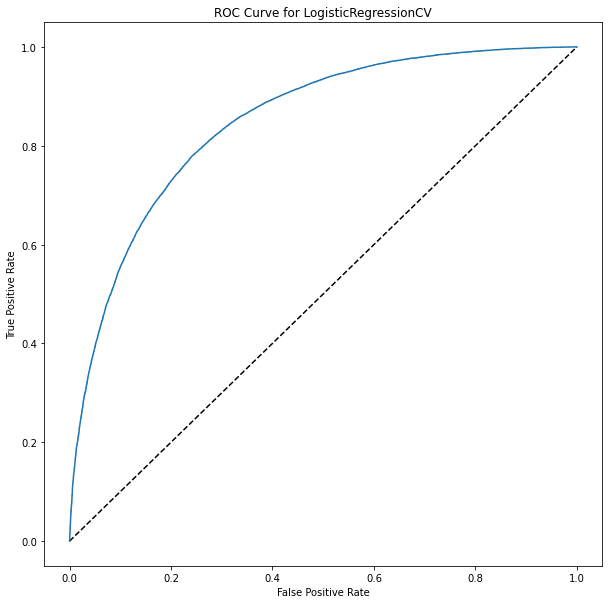

In [55]:
# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test_phone, pred_prob_log_clf)

# Plot ROC curve
plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for LogisticRegressionCV')
plt.show()



#### 2. Random Forest

In [56]:
# Instantiate and fit Random Forests Model
rf_clf = RandomForestClassifier(class_weight='balanced',n_jobs = -1).fit(X_train_tfidf_phone, y_train_phone)


pred_rf_clf = rf_clf.predict(X_test_tfidf_phone)

# Calculate F1 Score
metrics.f1_score(y_test_phone, pred_rf_clf)



0.7818505983319232

In [75]:
# Create the parameter grid
parameters = {'max_features': ['sqrt', 'auto'],
              'max_depth': [10, 50, None],
              'n_estimators': [50, 100]
              }

# Instantiate the grid search model
gs_rf = GridSearchCV(RandomForestClassifier(class_weight='balanced'), 
                     parameters, scoring='roc_auc', n_jobs=4, cv=3)

# Fit the grid search to the data
gs_rf.fit(X_train_tfidf_phone, y_train_phone)



/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


GridSearchCV(cv=3, estimator=RandomForestClassifier(class_weight='balanced'),
             n_jobs=4,
             param_grid={'max_depth': [10, 50, None],
                         'max_features': ['sqrt', 'auto'],
                         'n_estimators': [50, 100]},
             scoring='roc_auc')

In [76]:
# Get best parameters and best accuracy score
print('Best Score: ', gs_rf.best_score_)
print('Best Parameters: ', gs_rf.best_params_)

Best Score:  0.8187318379584817
Best Parameters:  {'max_depth': None, 'max_features': 'auto', 'n_estimators': 100}


In [77]:
# calculate predicted probabilities # keep probabilities for the positive outcome only
pred_prob_rf_clf = gs_rf.predict_proba(X_test_tfidf_phone)[:, 1]

In [78]:
# Determine ROC score
metrics.roc_auc_score(y_test_phone, pred_prob_rf_clf)

0.8229708612457867

In [79]:
# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test_phone, pred_prob_rf_clf)

# Plot ROC curve
plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], 'k--',label='No Skill')
plt.plot(fpr, tpr, label='Logistic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for RandomForestClassifier')
plt.show()

SyntaxError: invalid syntax (<ipython-input-79-5b2f6d082f83>, line 6)

### Thresholding for best model based on different business situation

- Adjust threshold of best classifier which is Logistic Regression

- The default threshold for interpreting probabilities to class labels is 0.5
      Prediction < 0.5 = Class 0
      Prediction >= 0.5 = Class 1
- Procedure for Thresholding:
      1. Fit Model on the Training Dataset.
      2. Predict Probabilities on the Test Dataset.
      3. For each threshold in Thresholds:
            3a. Convert probabilities to Class Labels using the threshold.
            3b. Evaluate Class Labels.
            3c. If Score is Better than Best Score.
            3ci. Adopt Threshold.
      4. Use Adopted Threshold When Making Class Predictions on New Data.



__Scoring metrics:__ 
    
    - Precision 
    - Recall
    - Balanced Accuracy (Accuracy determined for imbalanced datasets)
    - f1-score

#### I. __Business Case 1: Market Comparisons of the Cell Phones__

I will look at __balanced acccuracy__ and __confusion matrices__ to determined the best threshold to have best accuracy, and least number of false positives and false negatives.



In [57]:
# Create and print the confusion matrix for the LogReg Model
confusion_logreg = metrics.confusion_matrix(y_test_phone, pred_log_clf)
print(confusion_logreg)
print('-'* 17)
print(np.array([['TN', 'FP'],[ 'FN' , 'TP']]))

[[18222  7318]
 [ 5863 26760]]
-----------------
[['TN' 'FP']
 ['FN' 'TP']]


In [58]:
# Calculate balanced accuracy
balanced_accuracy_score(y_test_phone, pred_log_clf)

0.766874619280165

In [59]:
# define thresholds
thresholds_a =np.arange(0,1,.01)

In [60]:
# apply threshold to positive probabilities to create labels
def to_labels(y_pred_prob, threshold):
    return (y_pred_prob >= threshold).astype('int')

In [61]:
balanced_accuracy_points = [balanced_accuracy_score(y_test_phone, to_labels(pred_prob_log_clf, t)) for t in thresholds_a]

# get best threshold
ix1 = np.argmax(balanced_accuracy_points)

print('Best Threshold=%.3f' % (thresholds_a[ix1]))
print()
print('Highest Accuracy=%.5f'%(balanced_accuracy_points[ix1]))
print()
print(metrics.confusion_matrix(y_test_phone, to_labels(pred_prob_log_clf, thresholds_a[ix1])))

Best Threshold=0.540

Highest Accuracy=0.76858

[[19207  6333]
 [ 7010 25613]]


The threshold level of 0.54 provides the best results with a balanced accuracy of 0.768. In total there are 13343 mispredictions, 7010 false negatives and 6333 false positives.



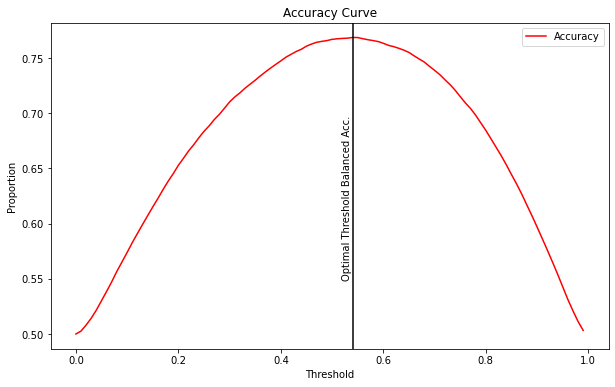

In [66]:
plt.figure(figsize=(10,6))

plt.plot(thresholds_a, balanced_accuracy_points, color='red')
plt.title('Accuracy Curve')
plt.legend(('Accuracy', 'Balanced Accuracy'))
plt.xlabel('Threshold')
plt.axvline(x=.54, color='black')
plt.text(.52,.55,'Optimal Threshold Balanced Acc.',rotation=90)
plt.ylabel('Proportion')
plt.show()

### II. Business Case 2: Customer Satisfaction

For this case we will target the negative or low rated reviews because negative (low rated) reviews helps sellers to understand the issue and to improve their products and services. To measure this I will use F1-score because it is a better measure when focusing on a specific class in this case low ratings. 

In [67]:
# Calculate Precision and Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test_phone, pred_prob_log_clf)
thresholds = np.append(thresholds, 1)

In [68]:
# Define a function to apply threshold to positive probabilities to create labels
def to_labels(y_pred_prob, threshold):
    return (y_pred_prob >= threshold).astype('int')

In [69]:
# evaluate each threshold
scores = [metrics.f1_score(y_test_phone, to_labels(pred_prob_log_clf, t), pos_label=0) for t in thresholds]

# get best threshold
ix = np.argmax(scores)

print('Best Threshold=%.3f, f1-Score=%.5f' % (thresholds[ix], scores[ix]))
print()
print('Classification_Report:')
print(metrics.classification_report(y_test_phone, to_labels(pred_prob_log_clf, thresholds[ix])))



Best Threshold=0.598, f1-Score=0.74550

Classification_Report:
              precision    recall  f1-score   support

           0       0.70      0.80      0.75     25540
           1       0.82      0.72      0.77     32623

    accuracy                           0.76     58163
   macro avg       0.76      0.76      0.76     58163
weighted avg       0.77      0.76      0.76     58163



The optimal threshold for this case is 0.598 with f1_score of 0.745.

Now lets plot the Precision, Recall and f1-Score on a graph together.




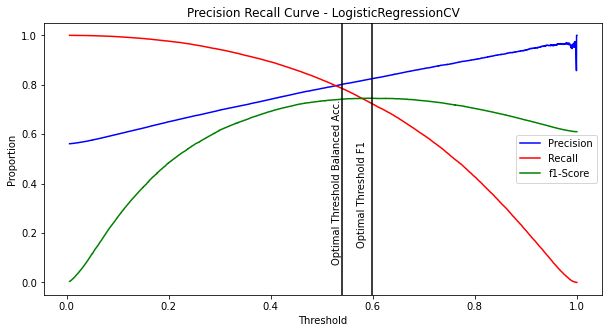

In [73]:
# Plot Precision, Recall and fbeta-Score on a graph together.

plt.figure(figsize=(10,5))
plt.plot(thresholds, precision, color='blue')
plt.plot(thresholds, recall, color='red')
plt.plot(thresholds, scores, color='green')
plt.title('Precision Recall Curve - LogisticRegressionCV')
plt.legend(('Precision', 'Recall', 'f1-Score'))
plt.xlabel('Threshold')
plt.ylabel('Proportion')
plt.axvline(x=.598, color='black')
plt.text(.57,.15,'Optimal Threshold F1',rotation=90)
plt.axvline(x=.54, color='black')
plt.text(.52,.08,'Optimal Threshold Balanced Acc.',rotation=90)
plt.show()

